In [2]:
import numpy as np
import netCDF4 as ncdf
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import glob as glob
import os as os
import sys as sys
from filter import raymond_lowpass
from scipy import signal


-0.0011853229586662312


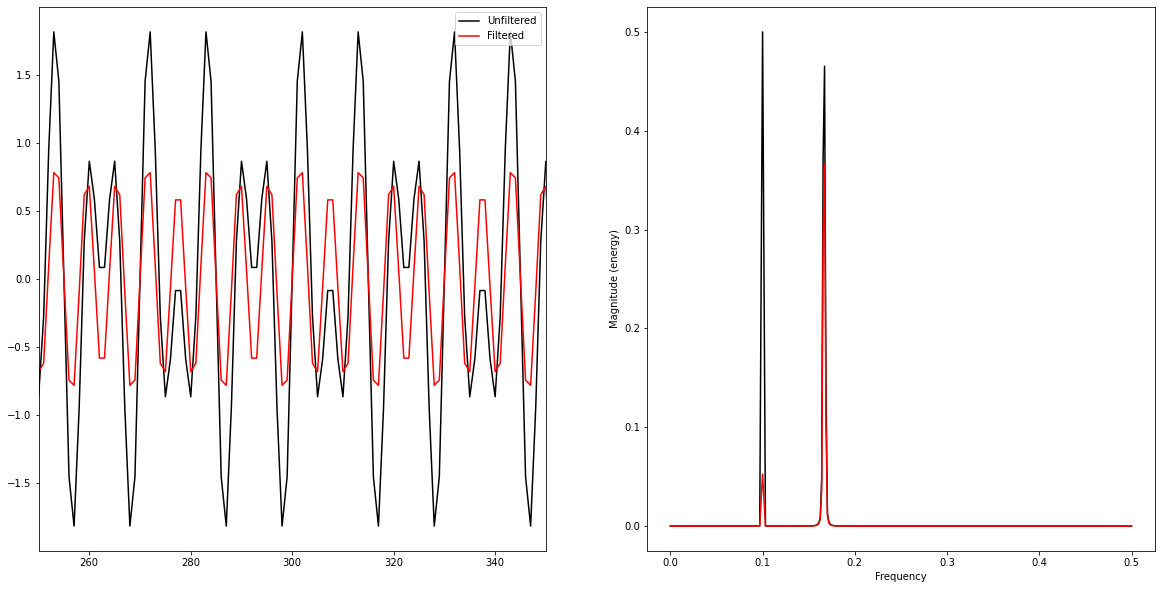

In [8]:
wave1 = [1.0,6.0]
wave2 = [1.0,10.0]
x     = np.arange(640)
eps   = 100.0

field = wave1[0]*np.sin(2.0*np.pi*x/wave1[1]) + wave2[0]*np.sin(2.0*np.pi*x/wave2[1])


ffield = field - raymond_lowpass.raymond1d_lowpass(field, eps)

diff = field - ffield

print(np.mean(diff))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

axes[0].plot(x, field, color='k', label='Unfiltered')
axes[0].set_xlim(250,350)
axes[0].plot(x, ffield, color='r', label='Filtered')
axes[0].legend(['Unfiltered', 'Filtered'])

line1 = axes[1].magnitude_spectrum(field, Fs=1.0, color='k')
line2 = axes[1].magnitude_spectrum(ffield, Fs=1.0, color='r')


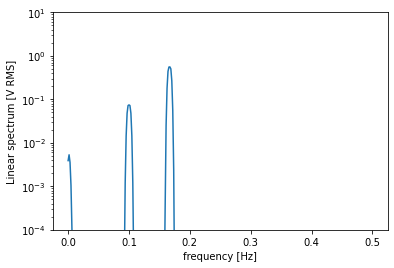

0.556891740400994

In [9]:
f, Pxx_spec = signal.periodogram(ffield, 1.0, 'flattop', scaling='spectrum')
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.ylim([1e-4, 1e1])
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()
np.sqrt(Pxx_spec.max())